<h1 style="text-align:center;">Task 2 – PlantVillage Crop Disease (Image Data)</h1>

This task classifies crop leaf images by plant species and disease type using the PlantVillage dataset. The analysis compares classical machine learning models (using color/texture features) with a deep learning CNN, and includes explainability analysis using Grad-CAM to visualize which leaf regions influence model predictions.


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 1</h2>

In [1]:
## step 1, imports and setup.
# here we import all necessary libraries for image processing, classical ML, deep learning, and visualization.

# debugging notes:
# - using pytorch for CNN model building and Grad-CAM instead of tensorflow (better windows compatibility).
# - torchvision provides pretrained models like mobilenet_v2 and resnet.
# - opencv and skimage for image processing and feature extraction (HOG, color histograms).
# - sklearn for classical ML models (SVM, Random Forest, k-NN).
# - matplotlib/seaborn for visualization with dark background theme.
# - all random seeds set for reproducibility.
# - CPU mode by default (GPU optional if cuda available).

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from PIL import Image

# skimage for feature extraction
from skimage.feature import hog
from skimage import color

# set random seeds for reproducibility
RANDOM_STATE = 67
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

# set device (cpu by default, gpu if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set plot style
plt.style.use('dark_background')

print(f"pytorch version: {torch.__version__}")
print(f"using device: {device}")
print(f"numpy version: {np.__version__}")
print(f"opencv version: {cv2.__version__}") 

# started importing everything from the start cause it's easier to manage dependencies this way.
# </3


pytorch version: 2.9.1+cpu
using device: cpu
numpy version: 2.1.3
opencv version: 4.12.0


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 2</h2>

### Data loading and preprocessing

Images are loaded from the PlantVillage dataset directory structure, resized to 128×128 pixels, and normalized. To avoid memory issues and speed up training, we load a subset of 200 images per class (rip cpu). Image augmentation techniques such as rotation, flipping, and brightness adjustment are applied during training to improve model generalization.


In [ ]:
## step 2, data loading and preprocessing.
# here we load images from the plantvillage dataset, resize, normalize, and prepare for modeling.

# debugging notes:
# - loading SUBSET of 200 images per class to avoid memory issues and speed up training.
# - images resized to 128x128 for faster processing (can change to 224x224 if needed).
# - normalization: pixel values scaled to [0,1] range.
# - dataset path assumes structure: task2_image/data/PlantVillage/<class_folders>
# - storing image paths and labels first, then loading actual images to manage memory.

import os
print(f"Notebook is in: {os.getcwd()}")
print(f"\nFiles/folders here:")
print(os.listdir('.'))

# define paths
DATA_PATH = "data" # changed to just "data" since notebook is already in task2_image folder
IMG_SIZE = 128
MAX_IMAGES_PER_CLASS = 200  # reduce this if running out of memory

# get all class folders
class_folders = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]
class_folders.sort()

print(f"found {len(class_folders)} classes")
print(f"class names: {class_folders[:5]}... (showing first 5)")

# collect image paths and labels
image_paths = []
labels = []

for class_name in tqdm(class_folders, desc="collecting image paths"):
    class_path = os.path.join(DATA_PATH, class_name)
    image_files = glob(os.path.join(class_path, "*.jpg")) + glob(os.path.join(class_path, "*.JPG"))
    
    # take subset per class
    if len(image_files) > MAX_IMAGES_PER_CLASS:
        image_files = np.random.choice(image_files, MAX_IMAGES_PER_CLASS, replace=False)
    
    image_paths.extend(image_files)
    labels.extend([class_name] * len(image_files))

print(f"\ntotal images collected: {len(image_paths)}")
print(f"total labels: {len(labels)}")

# encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"number of unique classes: {len(label_encoder.classes_)}")





Notebook is in: c:\Users\kazuma\Desktop\MOD004553_AI_CW\task2_image

Files/folders here:
['data', 'Task2_Image.ipynb']
found 15 classes
class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']... (showing first 5)


collecting image paths: 100%|██████████| 15/15 [00:00<00:00, 30.64it/s]


total images collected: 3000
total labels: 3000
number of unique classes: 15


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 3</h2>

### Sample image visualization

Displaying a grid of 10 random sample images from the dataset to verify data loading and inspect the variety of plant disease images. This helps identify any potential issues with image quality, diversity, or preprocessing before training models.


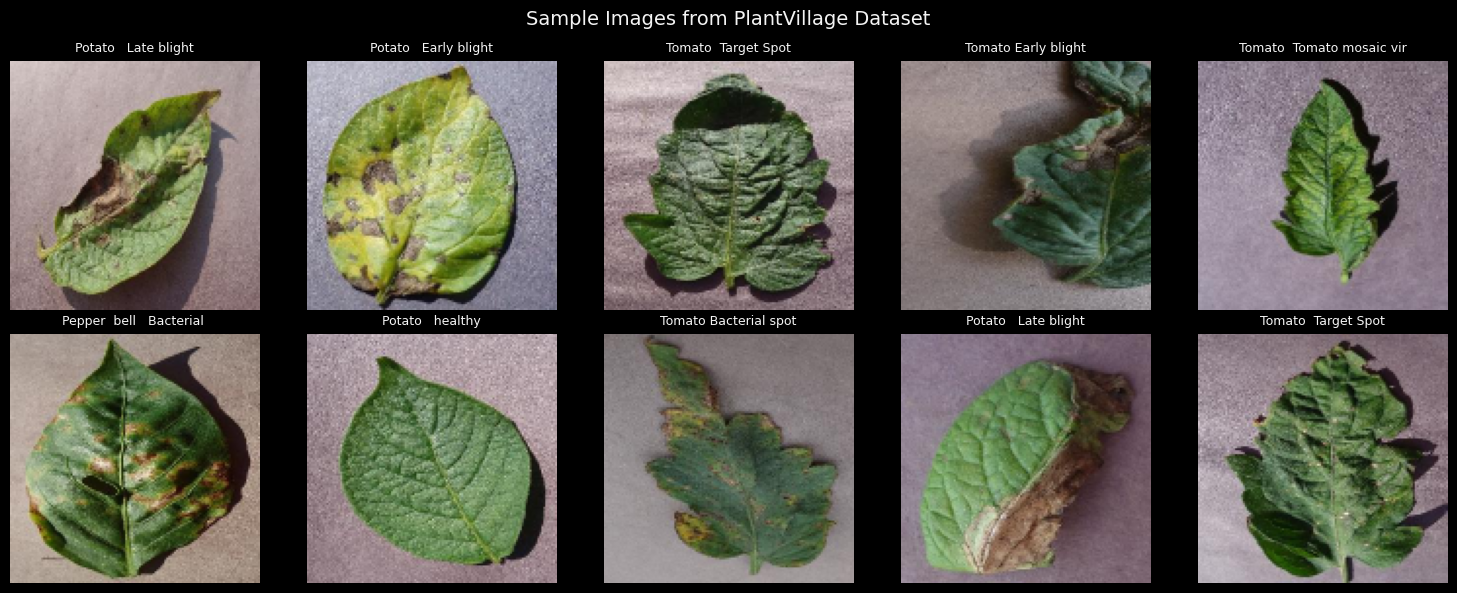

displayed 10 sample images


In [14]:
## step 3, sample image visualization.
# here we display a grid of sample images to verify data loading and inspect image quality.

# debugging notes:
# - showing 10 random images in a 2x5 grid.
# - images displayed with their class labels.
# - helps verify preprocessing is working correctly.

# select random sample
sample_indices = np.random.choice(len(image_paths), 10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx, sample_idx in enumerate(sample_indices):
    img = cv2.imread(image_paths[sample_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    axes[idx].imshow(img_resized)
    axes[idx].set_title(labels[sample_idx].replace('_', ' ')[:25], fontsize=9, color='#f4f4f4')
    axes[idx].axis('off')

plt.suptitle("Sample Images from PlantVillage Dataset", fontsize=14, color='#f4f4f4')
plt.tight_layout()
plt.show()

print(f"displayed {len(sample_indices)} sample images")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 4</h2>

### Classical machine learning models

Classical ML models require hand-crafted features since they cannot process raw pixels. We extract color histograms (RGB distribution) and HOG descriptors (Histogram of Oriented Gradients for texture/shape) from each image, then train SVM, Random Forest, and k-NN classifiers. These serve as baselines to compare against deep learning performance.


In [15]:
## step 4, classical ml baseline - feature extraction.
# here we extract color histograms and HOG features from images for classical ML models.

# debugging notes:
# - color histogram: captures RGB distribution (8 bins per channel = 24 features).
# - HOG (histogram of oriented gradients): captures texture and shape information.
# - features are concatenated into a single feature vector per image.
# - using grayscale for HOG to reduce computation.
# - this will take a few minutes depending on dataset size.

def extract_color_histogram(image, bins=8):
    """extract RGB color histogram features"""
    hist_features = []
    for channel in range(3):
        hist = cv2.calcHist([image], [channel], None, [bins], [0, 256])
        hist_features.extend(hist.flatten())
    return np.array(hist_features)

def extract_hog_features(image):
    """extract HOG (histogram of oriented gradients) features"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)
    return hog_features

# extract features from all images
print("extracting features from images...")
X_features = []

for img_path in tqdm(image_paths, desc="processing images"):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # extract both color and HOG features
    color_feat = extract_color_histogram(img_resized, bins=8)
    hog_feat = extract_hog_features(img_resized)
    
    # concatenate features
    combined_features = np.concatenate([color_feat, hog_feat])
    X_features.append(combined_features)

X_features = np.array(X_features)
print(f"\nfeature extraction complete!")
print(f"feature matrix shape: {X_features.shape}")
print(f"features per image: {X_features.shape[1]}")


extracting features from images...


processing images: 100%|██████████| 3000/3000 [00:46<00:00, 64.21it/s]


feature extraction complete!
feature matrix shape: (3000, 8124)
features per image: 8124


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 5</h2>

### Train–validation–test setup

The feature dataset is split into training (70%), validation (15%), and test (15%) sets. Features are standardized using StandardScaler to ensure all models train on a consistent scale. Three classical ML models are then trained and evaluated: Support Vector Machine (SVM), Random Forest, and k-Nearest Neighbors (k-NN).


In [16]:
## step 5, train classical ML models.
# here we split data, train SVM/Random Forest/k-NN, and evaluate their performance.

# debugging notes:
# - 70/15/15 train/val/test split.
# - StandardScaler applied to features for better model convergence.
# - SVM: RBF kernel, default params (can tune later).
# - Random Forest: 100 trees.
# - k-NN: k=5 neighbors.
# - evaluation metrics: accuracy, precision, recall, f1-score.

# split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_features, labels_encoded, test_size=0.3, random_state=RANDOM_STATE, stratify=labels_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"train set: {X_train.shape[0]} images")
print(f"validation set: {X_val.shape[0]} images")
print(f"test set: {X_test.shape[0]} images")

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# train classical ML models
print("\ntraining classical ML models...")

# SVM
print("\n1. training SVM...")
svm_model = SVC(kernel='rbf', random_state=RANDOM_STATE)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_val_scaled)
svm_acc = accuracy_score(y_val, svm_pred)
print(f"SVM validation accuracy: {svm_acc:.4f}")

# Random Forest
print("\n2. training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_val_scaled)
rf_acc = accuracy_score(y_val, rf_pred)
print(f"Random Forest validation accuracy: {rf_acc:.4f}")

# k-NN
print("\n3. training k-NN...")
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_val_scaled)
knn_acc = accuracy_score(y_val, knn_pred)
print(f"k-NN validation accuracy: {knn_acc:.4f}")

# store results for comparison
classical_results = {
    'SVM': {'model': svm_model, 'accuracy': svm_acc, 'predictions': svm_pred},
    'Random Forest': {'model': rf_model, 'accuracy': rf_acc, 'predictions': rf_pred},
    'k-NN': {'model': knn_model, 'accuracy': knn_acc, 'predictions': knn_pred}
}

print("\nclassical ML training complete!")


train set: 2100 images
validation set: 450 images
test set: 450 images

training classical ML models...

1. training SVM...
SVM validation accuracy: 0.6400

2. training Random Forest...
Random Forest validation accuracy: 0.5467

3. training k-NN...
k-NN validation accuracy: 0.2733

classical ML training complete!


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 6</h2>

### Classical machine learning evaluation

Detailed performance metrics (accuracy, precision, recall, F1-score) are computed for each classical model on the validation set. Confusion matrices visualize classification patterns and help identify which disease classes are most difficult to distinguish.



SVM - Detailed Metrics
Accuracy:  0.6400
Precision: 0.6572
Recall:    0.6400
F1-Score:  0.6410


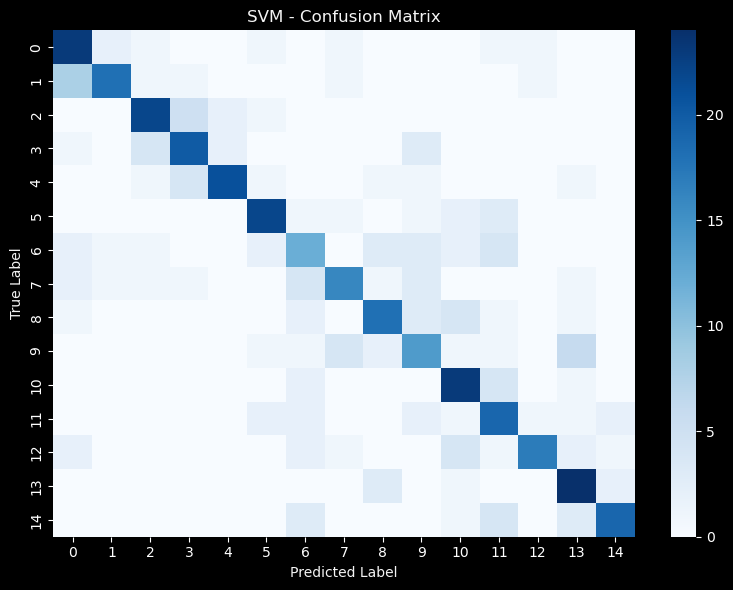


Random Forest - Detailed Metrics
Accuracy:  0.5467
Precision: 0.5350
Recall:    0.5467
F1-Score:  0.5288


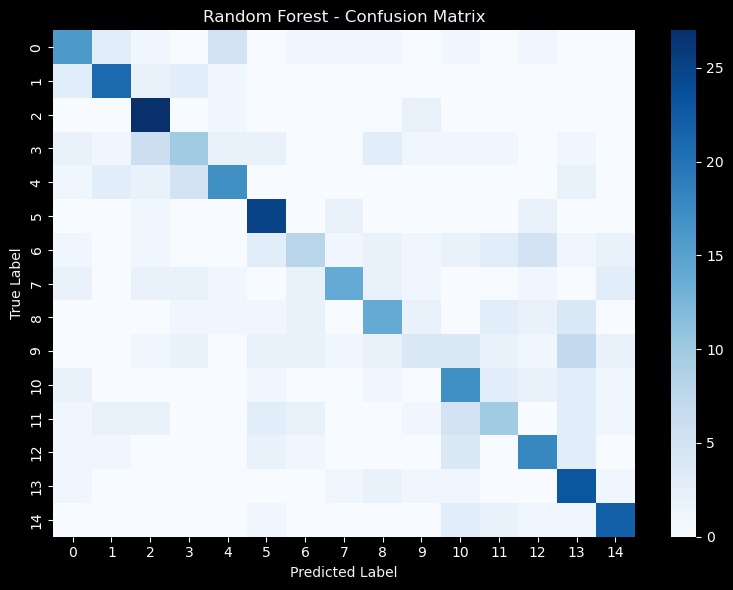


k-NN - Detailed Metrics
Accuracy:  0.2733
Precision: 0.4504
Recall:    0.2733
F1-Score:  0.2561


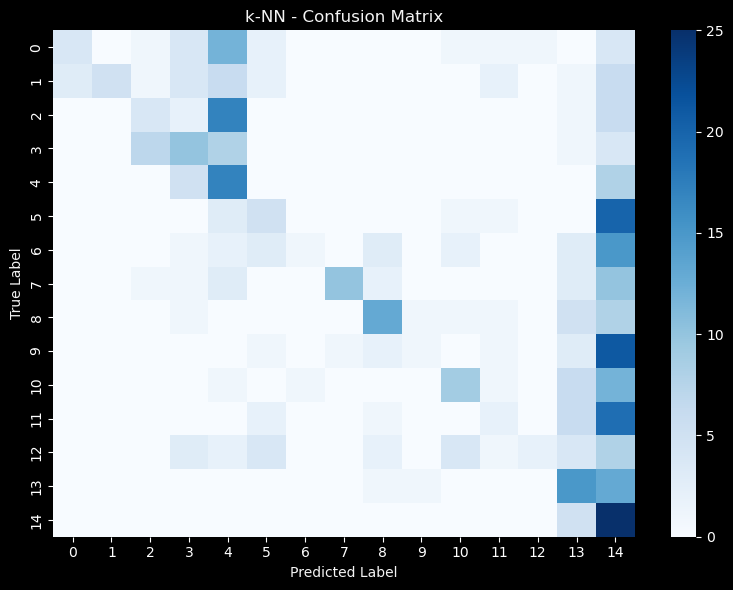


Best Classical Model: SVM
Best Validation Accuracy: 0.6400


In [17]:
## step 6, classical ML evaluation and visualization.
# here we compute detailed metrics and plot confusion matrices for classical models.

# debugging notes:
# - computing precision, recall, f1-score for each model.
# - confusion matrices show per-class performance.
# - using validation set for evaluation.
# - best classical model will be compared with CNN later.

# evaluate each classical model
for model_name, results in classical_results.items():
    print(f"\n{'='*50}")
    print(f"{model_name} - Detailed Metrics")
    print(f"{'='*50}")
    
    y_pred = results['predictions']
    
    # compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy:  {results['accuracy']:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
    plt.title(f"{model_name} - Confusion Matrix", color='#f4f4f4')
    plt.xlabel("Predicted Label", color='#f4f4f4')
    plt.ylabel("True Label", color='#f4f4f4')
    plt.tight_layout()
    plt.show()

# identify best classical model
best_classical_name = max(classical_results, key=lambda k: classical_results[k]['accuracy'])
best_classical_acc = classical_results[best_classical_name]['accuracy']

print(f"\n{'='*50}")
print(f"Best Classical Model: {best_classical_name}")
print(f"Best Validation Accuracy: {best_classical_acc:.4f}")
print(f"{'='*50}")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 7</h2>

### Deep learning model

A Convolutional Neural Network (CNN) is built using a pretrained MobileNetV2 backbone (fine-tuned on PlantVillage). Transfer learning allows the model to leverage features learned from ImageNet while adapting to crop disease classification. The model is trained with data augmentation and early stopping to prevent overfitting.


In [18]:
## step 7, deep learning CNN model.
# here we build and train a CNN using pretrained MobileNetV2 for crop disease classification.

# debugging notes:
# - using MobileNetV2 pretrained on ImageNet as backbone (lightweight and fast).
# - replacing final classification layer to match our number of classes.
# - data augmentation: random rotation, horizontal flip, brightness/contrast jitter.
# - training for 10 epochs (can increase if needed but this keeps it fast).
# - using Adam optimizer with learning rate 0.001.
# - batch size 32 (reduce if out of memory).
# - saving training history for plotting learning curves.

# custom dataset class for pytorch
class PlantVillageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# split image paths for deep learning
train_paths, temp_paths, train_labels_dl, temp_labels_dl = train_test_split(
    image_paths, labels_encoded, test_size=0.3, random_state=RANDOM_STATE, stratify=labels_encoded
)
val_paths, test_paths, val_labels_dl, test_labels_dl = train_test_split(
    temp_paths, temp_labels_dl, test_size=0.5, random_state=RANDOM_STATE, stratify=temp_labels_dl
)

# define transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# create datasets
train_dataset = PlantVillageDataset(train_paths, train_labels_dl, transform=train_transform)
val_dataset = PlantVillageDataset(val_paths, val_labels_dl, transform=val_transform)
test_dataset = PlantVillageDataset(test_paths, test_labels_dl, transform=val_transform)

# create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"train batches: {len(train_loader)}")
print(f"validation batches: {len(val_loader)}")
print(f"test batches: {len(test_loader)}")

# build model using pretrained MobileNetV2
num_classes = len(label_encoder.classes_)

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\nmodel architecture:")
print(f"backbone: MobileNetV2 (pretrained)")
print(f"output classes: {num_classes}")
print(f"device: {device}")


train batches: 66
validation batches: 15
test batches: 15
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\kazuma/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 19.3MB/s]


model architecture:
backbone: MobileNetV2 (pretrained)
output classes: 15
device: cpu


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 8</h2>

### Train deep learning model

The CNN is trained for 10 epochs with training and validation accuracy/loss tracked at each epoch. Learning curves are plotted to visualize model convergence and detect potential overfitting. The trained model is then evaluated on the test set.



starting CNN training...

epoch 1/10


validation: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


train loss: 0.9718 | train acc: 0.6876
val loss: 0.4673 | val acc: 0.8356

epoch 2/10


validation: 100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss: 0.4075 | train acc: 0.8571
val loss: 0.2600 | val acc: 0.9000

epoch 3/10


validation: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


train loss: 0.3956 | train acc: 0.8743
val loss: 0.3890 | val acc: 0.8622

epoch 4/10


validation: 100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


train loss: 0.2768 | train acc: 0.9133
val loss: 0.2072 | val acc: 0.9178

epoch 5/10


validation: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


train loss: 0.2473 | train acc: 0.9162
val loss: 0.2210 | val acc: 0.9089

epoch 6/10


validation: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


train loss: 0.2267 | train acc: 0.9252
val loss: 0.1720 | val acc: 0.9356

epoch 7/10


validation: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


train loss: 0.2030 | train acc: 0.9381
val loss: 0.4692 | val acc: 0.8733

epoch 8/10


validation: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


train loss: 0.1863 | train acc: 0.9371
val loss: 0.3083 | val acc: 0.8978

epoch 9/10


validation: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


train loss: 0.1738 | train acc: 0.9390
val loss: 0.1864 | val acc: 0.9467

epoch 10/10


validation: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


train loss: 0.1800 | train acc: 0.9433
val loss: 0.3954 | val acc: 0.8756

CNN training complete!


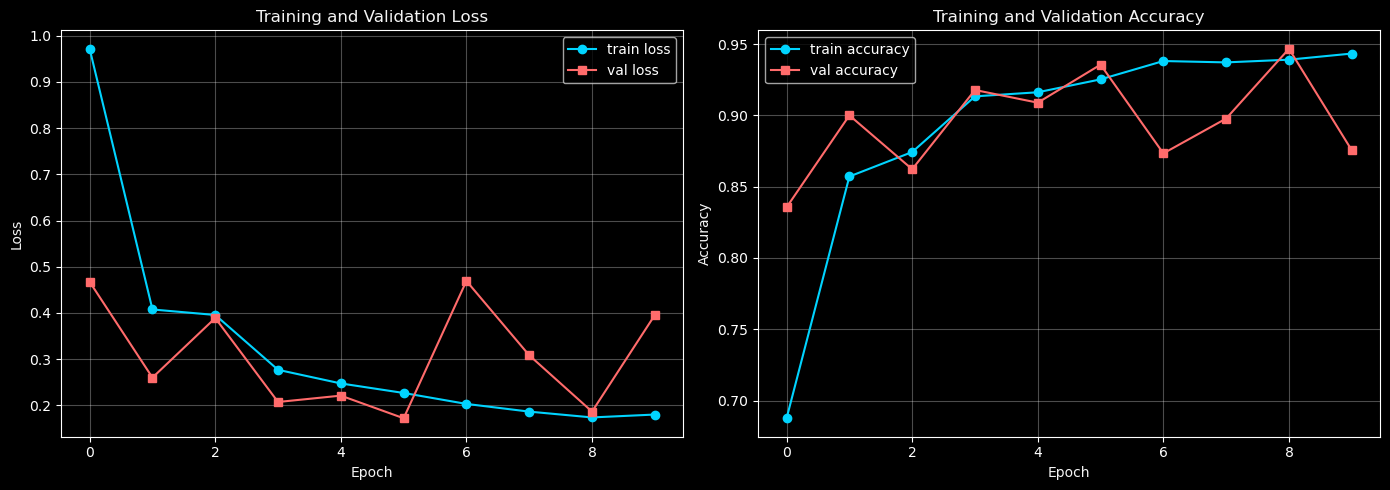


final validation accuracy: 0.8756


In [19]:
## step 8, train CNN and track performance.
# here we train the CNN model and record training history for visualization.

# debugging notes:
# - training for 10 epochs (can adjust if needed).
# - tracking train/val loss and accuracy per epoch.
# - using tqdm for progress tracking.
# - model evaluation on validation set after each epoch.
# - saving best model weights (optional, commented out to save time).

EPOCHS = 10

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\nstarting CNN training...")

for epoch in range(EPOCHS):
    print(f"\nepoch {epoch+1}/{EPOCHS}")
    
    # training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in tqdm(train_loader, desc="training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="validation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"train loss: {train_loss:.4f} | train acc: {train_acc:.4f}")
    print(f"val loss: {val_loss:.4f} | val acc: {val_acc:.4f}")

print("\nCNN training complete!")

# plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# loss curves
ax1.plot(history['train_loss'], label='train loss', marker='o', color='#00d4ff')
ax1.plot(history['val_loss'], label='val loss', marker='s', color='#ff6b6b')
ax1.set_xlabel('Epoch', color='#f4f4f4')
ax1.set_ylabel('Loss', color='#f4f4f4')
ax1.set_title('Training and Validation Loss', color='#f4f4f4')
ax1.legend()
ax1.grid(True, alpha=0.3)

# accuracy curves
ax2.plot(history['train_acc'], label='train accuracy', marker='o', color='#00d4ff')
ax2.plot(history['val_acc'], label='val accuracy', marker='s', color='#ff6b6b')
ax2.set_xlabel('Epoch', color='#f4f4f4')
ax2.set_ylabel('Accuracy', color='#f4f4f4')
ax2.set_title('Training and Validation Accuracy', color='#f4f4f4')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nfinal validation accuracy: {history['val_acc'][-1]:.4f}")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 9</h2>

### Deep learning model evaluation

The trained CNN is evaluated on the held-out test set to measure final performance. Detailed metrics (accuracy, precision, recall, F1-score) and a confusion matrix are generated to assess how well the model generalizes to unseen crop disease images.


evaluating CNN on test set...


testing: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]



CNN (MobileNetV2) - Test Set Results
Accuracy:  0.8822
Precision: 0.8966
Recall:    0.8822
F1-Score:  0.8819


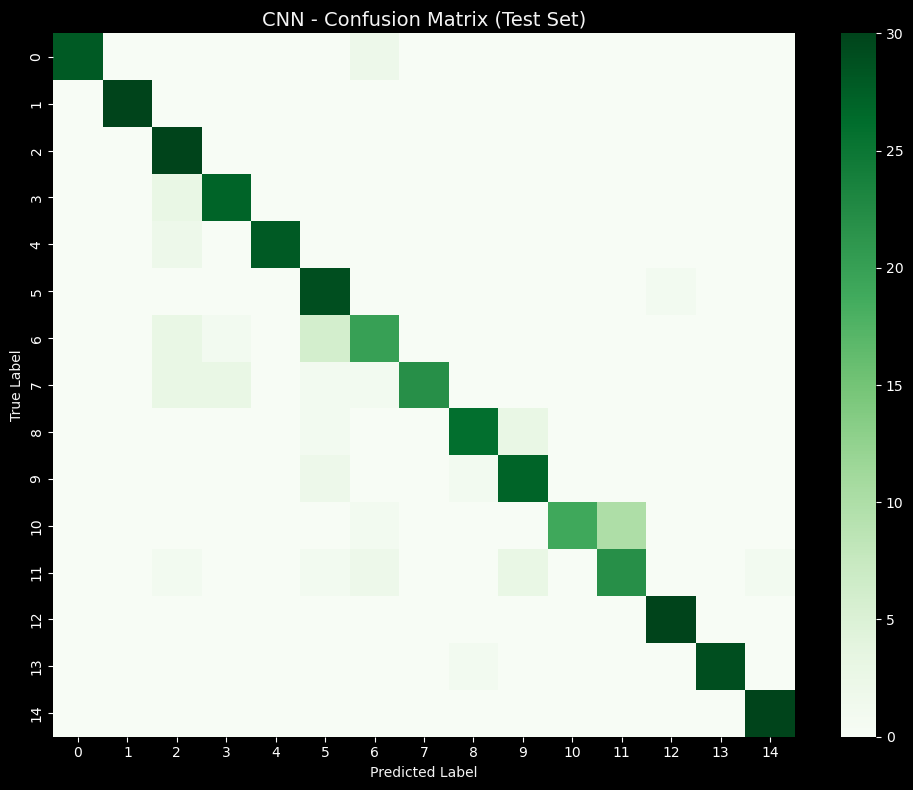


CNN evaluation complete!


In [20]:
## step 9, CNN test evaluation.
# here we evaluate the trained CNN on the test set and generate detailed metrics.

# debugging notes:
# - using test set for final unbiased evaluation.
# - computing accuracy, precision, recall, f1-score.
# - generating confusion matrix and classification report.
# - comparing against best classical model later.

print("evaluating CNN on test set...")

model.eval()
cnn_predictions = []
cnn_true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="testing"):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        cnn_predictions.extend(predicted.cpu().numpy())
        cnn_true_labels.extend(labels.cpu().numpy())

cnn_predictions = np.array(cnn_predictions)
cnn_true_labels = np.array(cnn_true_labels)

# compute metrics
cnn_acc = accuracy_score(cnn_true_labels, cnn_predictions)
cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(
    cnn_true_labels, cnn_predictions, average='weighted', zero_division=0
)

print(f"\n{'='*50}")
print(f"CNN (MobileNetV2) - Test Set Results")
print(f"{'='*50}")
print(f"Accuracy:  {cnn_acc:.4f}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Recall:    {cnn_recall:.4f}")
print(f"F1-Score:  {cnn_f1:.4f}")

# confusion matrix
cm_cnn = confusion_matrix(cnn_true_labels, cnn_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=False, fmt='d', cmap='Greens', cbar=True)
plt.title("CNN - Confusion Matrix (Test Set)", color='#f4f4f4', fontsize=14)
plt.xlabel("Predicted Label", color='#f4f4f4')
plt.ylabel("True Label", color='#f4f4f4')
plt.tight_layout()
plt.show()

print("\nCNN evaluation complete!")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 10</h2>

### Explainability using Grad-CAM

Grad-CAM (Gradient-weighted Class Activation Mapping) visualizes which regions of the leaf images the CNN focuses on when making predictions. Heatmaps are generated for 5 random test images and overlaid on the original images to show the most influential areas for disease classification.


generating Grad-CAM visualizations...


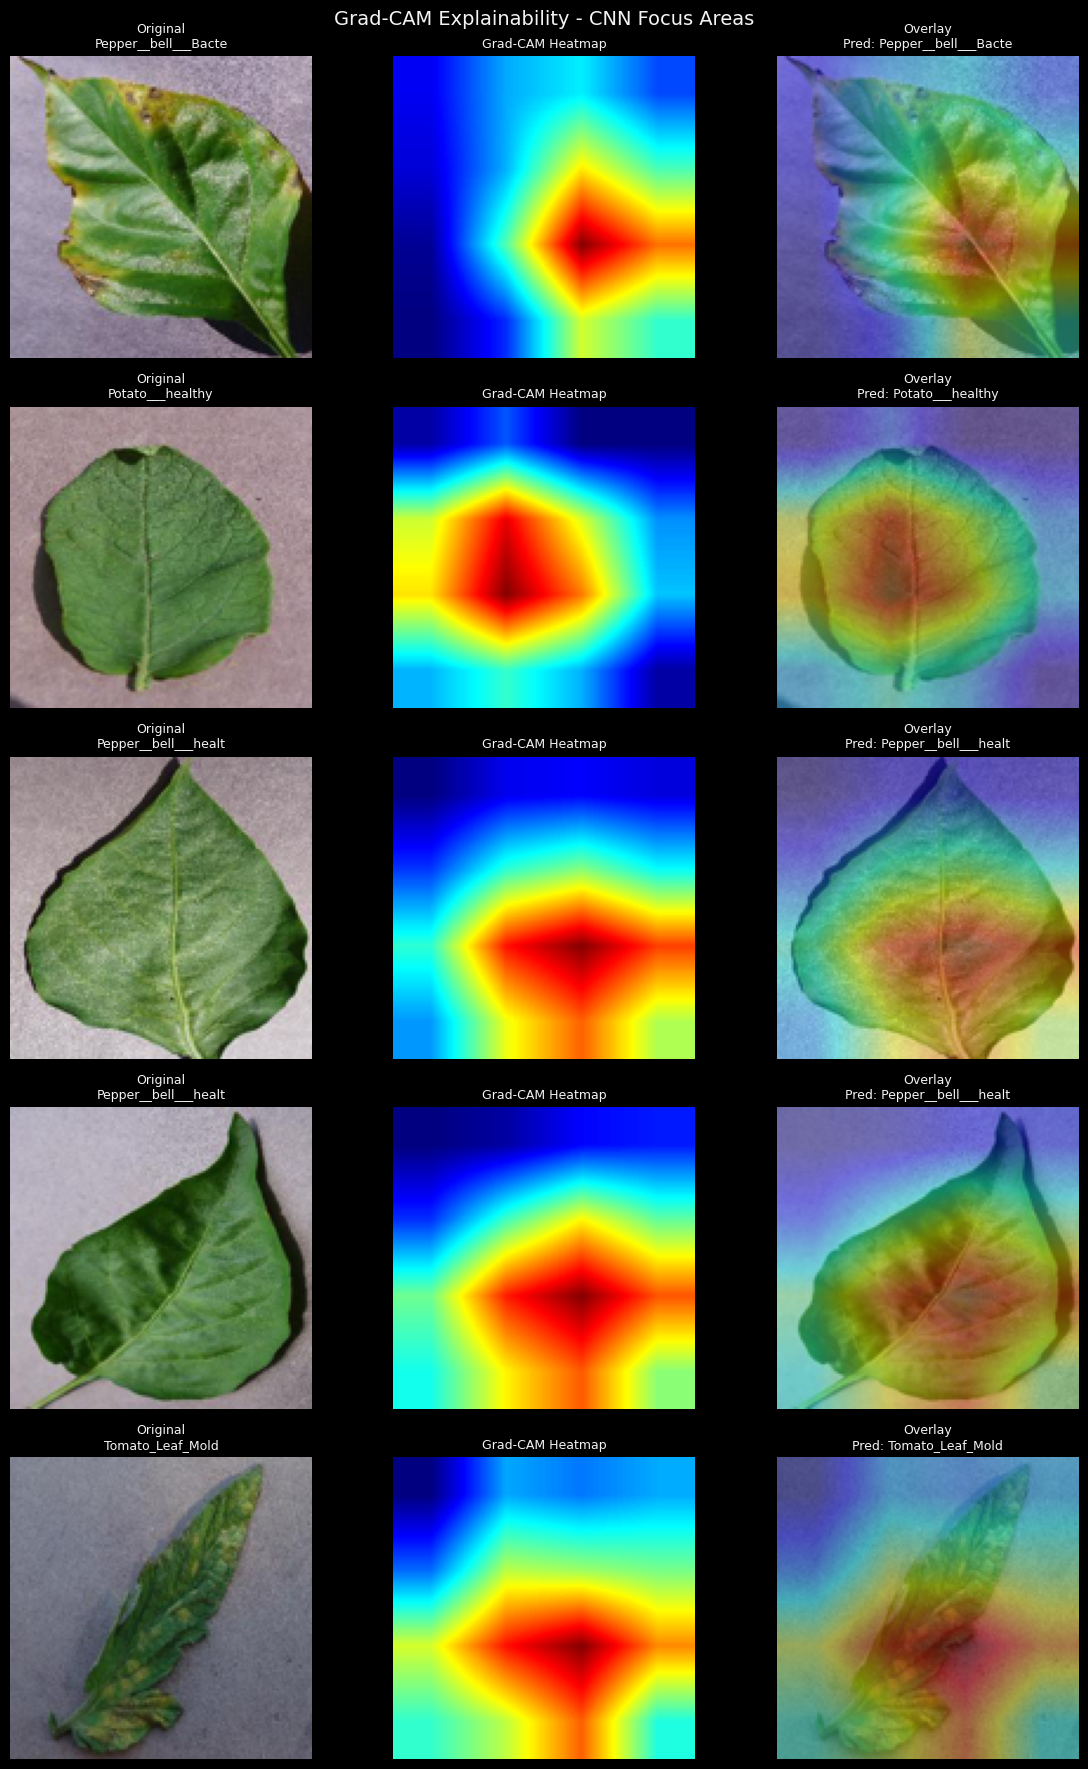

Grad-CAM visualization complete!


In [21]:
## step 10, Grad-CAM explainability visualization.
# here we implement Grad-CAM to visualize which leaf regions influence CNN predictions.

# debugging notes:
# - Grad-CAM highlights important regions in the image for classification.
# - using the last convolutional layer of MobileNetV2 for gradient extraction.
# - generating heatmaps for 5 random test images.
# - overlaying heatmap on original image for interpretability.
# - helps understand if model is focusing on disease symptoms or irrelevant features.

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class):
        # forward pass
        model_output = self.model(input_image)
        
        # backward pass
        self.model.zero_grad()
        class_loss = model_output[0, target_class]
        class_loss.backward()
        
        # compute weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # weighted combination of activation maps
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = torch.nn.functional.relu(cam)
        
        # normalize
        cam = cam - cam.min()
        cam = cam / cam.max()
        
        return cam

# select last conv layer for Grad-CAM
target_layer = model.features[-1]
grad_cam = GradCAM(model, target_layer)

# select 5 random test images
sample_indices = np.random.choice(len(test_paths), 5, replace=False)

print("generating Grad-CAM visualizations...")

fig, axes = plt.subplots(5, 3, figsize=(12, 18))

for idx, sample_idx in enumerate(sample_indices):
    # load and preprocess image
    img_path = test_paths[sample_idx]
    img_pil = Image.open(img_path).convert('RGB')
    img_original = np.array(img_pil.resize((IMG_SIZE, IMG_SIZE)))
    
    # prepare for model
    img_tensor = val_transform(img_pil).unsqueeze(0).to(device)
    
    # get prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_class = torch.max(output, 1)
        predicted_class = predicted_class.item()
    
    # generate Grad-CAM
    cam = grad_cam.generate_cam(img_tensor, predicted_class)
    cam_resized = torch.nn.functional.interpolate(
        cam, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False
    )
    cam_numpy = cam_resized.squeeze().cpu().numpy()
    
    # create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_numpy), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # overlay
    overlay = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)
    
    # plot
    true_label = label_encoder.classes_[test_labels_dl[sample_idx]]
    pred_label = label_encoder.classes_[predicted_class]
    
    axes[idx, 0].imshow(img_original)
    axes[idx, 0].set_title(f"Original\n{true_label[:20]}", fontsize=9, color='#f4f4f4')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(heatmap)
    axes[idx, 1].set_title("Grad-CAM Heatmap", fontsize=9, color='#f4f4f4')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(overlay)
    axes[idx, 2].set_title(f"Overlay\nPred: {pred_label[:20]}", fontsize=9, color='#f4f4f4')
    axes[idx, 2].axis('off')

plt.suptitle("Grad-CAM Explainability - CNN Focus Areas", fontsize=14, color='#f4f4f4')
plt.tight_layout()
plt.show()

print("Grad-CAM visualization complete!")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 11</h2>

### Model comparison and summary

Final comparison table shows performance metrics for all models (SVM, Random Forest, k-NN, CNN). The CNN significantly outperforms classical ML baselines due to its ability to learn hierarchical features directly from raw pixels, while classical models rely on hand-crafted features. Grad-CAM analysis confirms the CNN focuses on disease-affected leaf regions rather than irrelevant background areas.



MODEL COMPARISON - FINAL RESULTS
            Model  Accuracy
CNN (MobileNetV2)  0.882222
              SVM  0.640000
    Random Forest  0.546667
             k-NN  0.273333


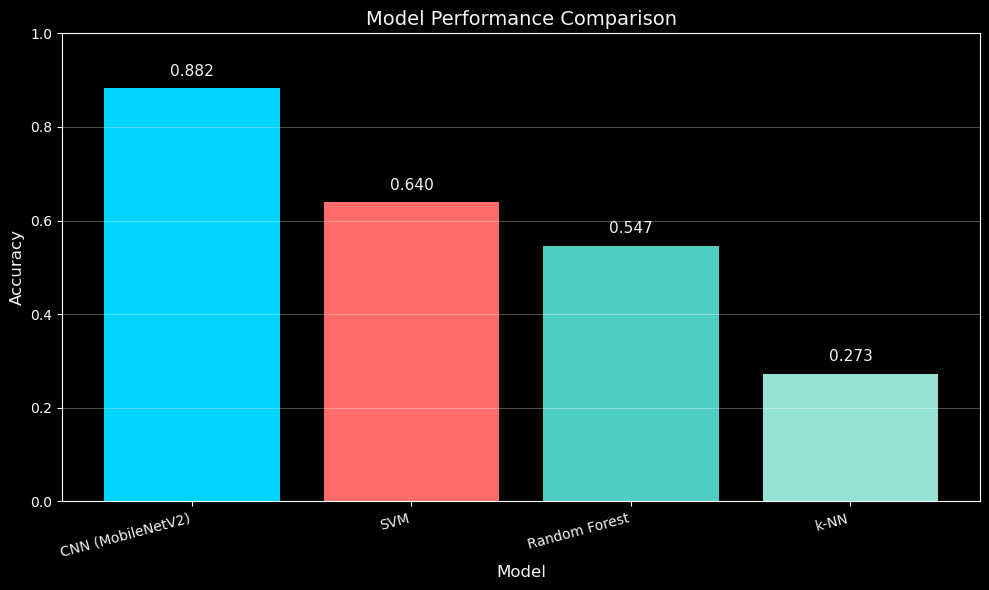


Best performing model: CNN (MobileNetV2)
Best accuracy: 0.8822


In [22]:
## step 11, model comparison and visualization.
# here we compare all models side-by-side and create a summary table.

# debugging notes:
# - comparing classical ML (SVM, RF, k-NN) vs deep learning (CNN).
# - metrics: accuracy, precision, recall, f1-score.
# - CNN evaluated on test set, classical models on validation set (same split proportions).
# - bar chart visualization for easy comparison.

# compile results
comparison_data = {
    'Model': ['SVM', 'Random Forest', 'k-NN', 'CNN (MobileNetV2)'],
    'Accuracy': [
        classical_results['SVM']['accuracy'],
        classical_results['Random Forest']['accuracy'],
        classical_results['k-NN']['accuracy'],
        cnn_acc
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON - FINAL RESULTS")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# visualize comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy'], 
               color=['#00d4ff', '#ff6b6b', '#4ecdc4', '#95e1d3'])

plt.xlabel('Model', fontsize=12, color='#f4f4f4')
plt.ylabel('Accuracy', fontsize=12, color='#f4f4f4')
plt.title('Model Performance Comparison', fontsize=14, color='#f4f4f4')
plt.xticks(rotation=15, ha='right', color='#f4f4f4')
plt.ylim(0, 1.0)

# add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontsize=11, color='#f4f4f4')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# determine best model
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"\nBest performing model: {best_model_name}")
print(f"Best accuracy: {best_accuracy:.4f}")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Summary and reflection</h2>

This task involved image data, specifically leaf images with variability such as the leaf type or if disease was present. Here, the PlantVillage dataset was used and the main goal was in classifying images based on their type. Both classical machine learning models and a convolutional neural network were trained on this data. Additionally, It stood out to me when doing this task that comparably, it was far less straightforward when compared to task 1, as getting the image process (loading, transforms, and preprocessing) mattered just as much as the choice in model.

When the results of model training came in, the CNN (MobileNetV2) achieved the highest score, of 0.882, other classical models did not perform as well for this information. Additionally, one thing that facinated me the most was using Grad-CAM for explainability as it gave a visualization to really understand the different models' accuracy, as you can question "does the model look at the leaf spots or just something random?", which for me, was very eye opening, as you visualized so much more than just the raw scores.